In [1]:
# Uncomment and run this when using colab. 
#%pip install pygeoinf

# Tutorial 4 - Linear operators

In this tutorial, we consider the implementation of linear operators within the ```pygeoinf``` library through the ```LinearOperator``` class. 

### Defining a linear operator

Let $X$ and $Y$ be two Hilbert spaces represented by ```HilbertSpace``` objects. A linear operator between them is specified through its mapping. This is shown in the following example using instances of ```EuclideanSpace``` as the domain and codomain of the mapping. 

In [2]:
import numpy as np
from pygeoinf import EuclideanSpace, LinearOperator

# Set the domain of the operator. 
X = EuclideanSpace(5)

# Set the codomain of the operator. 
Y = EuclideanSpace(3)

# Define the linear operator as a projection from X to Y. 
A = LinearOperator(X, Y, lambda x : x[:Y.dim])

Having defined the operator, we can compute its action on vectors as follows:

In [3]:
x = X.random()
print(f'x =  {x}')

y = A(x)
print(f'Ax = {y}')

x =  [ 0.2136835   1.51910283 -0.8453952   0.02289203  1.74288814]
Ax = [ 0.2136835   1.51910283 -0.8453952 ]


Linear operators can be combined in the usual manners so long as their domains and codomains are compatible. For example:

In [4]:
# Project the final elements onto Y. 
B = LinearOperator(X, Y, lambda x : x[-Y.dim:])

x = X.random()
print(f'x          = {x}')

y = A(x) 
print(f'Ax         = {y}')

w = B(x)
print(f'Bx         = {w}')

C = A + 2 * B
z = C(x)
print(f'(A + 2 B)x = {z}')
print(f'Ax + 2 Bx  = {y+2*w}')

# Inclusion of Y into X. 
D = LinearOperator(Y, X, lambda y : np.concatenate([y, np.zeros(X.dim-Y.dim)]))

E = D @ A
print(f'D(Ax)      = {D(A(x))}')
print(f'(DA)x      = {E(x)}')

x          = [-0.27189577 -1.25228333 -2.36130252 -1.23953853  0.30193946]
Ax         = [-0.27189577 -1.25228333 -2.36130252]
Bx         = [-2.36130252 -1.23953853  0.30193946]
(A + 2 B)x = [-4.99450081 -3.73136039 -1.7574236 ]
Ax + 2 Bx  = [-4.99450081 -3.73136039 -1.7574236 ]
D(Ax)      = [-0.27189577 -1.25228333 -2.36130252  0.          0.        ]
(DA)x      = [-0.27189577 -1.25228333 -2.36130252  0.          0.        ]


Algebraic combinations of such operators are always detemrined lazily, and hence there is essentially no cost in forming the combinations until their action on a vector is computed. 



### Dual operators

For a linear operator, $A \in \mathrm{Hom}(X,Y)$, the corresponding **dual operator**, $A' \in \mathrm{Hom}(Y',X')$ is defined through
$$
\langle y', Ax \rangle = \langle A'y', x \rangle, 
$$
for all $x \in X$ and $y' \in Y'$. Such an operator can be accessed from a ```LinearOperator``` using its ```dual``` property. This is shown in the code below where we verify that the defining identity holds. 

In [5]:
x = X.random()
yp = Y.dual.random()

print(f'<yp, Ax>    = {yp(A(x))}')
print(f'<Ap(yp), x> = {A.dual(yp)(x)}')

<yp, Ax>    = -0.15307494589446424
<Ap(yp), x> = -0.15307494589446424


Here we see that once a ```LinearOperator``` has been defined its dual is automatically available. This is done internally using the defining relation for the dual operator. However, this implementation is inefficient and should be used rarely. Indeed, the action of of this dual operator on a vector of dimension $n$ requires $n$ actions of the original operator to be computed. Rather, when constructing a ```LinearOperator``` the dual mapping can be provided directly as a key-word argument. 

Consider the projection operator, $A$, defined above. In this case we see that 
$$
\langle y', Ax \rangle = \sum_{i=1}^{m} y'_{i} x_{i}, 
$$
where $m = \dim Y$. It follows that $A'y'$ is the element of  $X'$ whose first $m$ components equal those of $y'$
while all others are zero. Using this result, we can re-implement the projection operator as follows:


In [6]:
# Define the mapping and the dual mapping
def mapping(x):
    return x[:Y.dim]

def dual_mapping(yp):
    cyp = Y.dual.to_components(yp)
    cxp = np.concatenate([cyp, np.zeros(X.dim-Y.dim)])
    return X.dual.from_components(cxp)

# Construct the operator. 
A = LinearOperator(X, Y, mapping, dual_mapping=dual_mapping)

# Check that it performs as required. 
x = X.random()
yp = Y.dual.random()

print(f'<yp, Ax>    = {yp(A(x))}')
print(f'<Ap(yp), x> = {A.dual(yp)(x)}')


<yp, Ax>    = -3.1588724465652547
<Ap(yp), x> = -3.1588724465652547


### Adjoint operators

For $A \in \mathrm{Hom}(X,Y)$ we can also define its **adjoint operator**, $A^{*} \in \mathrm{Hom}(Y, X)$, through
$$
(y, Ax)_{Y} = (A^{*}y, x)_{X}, 
$$
for all $x \in X$ and $y \in Y$. For a ```LinearOperator``` the adjoint can be accessed through its ```adjoint``` property:

In [7]:
# Define the projection again just in terms of its mapping. 
A = LinearOperator(X, Y, mapping)

x = X.random()
y = Y.random()

print(f'(y,Ax)  = {Y.inner_product(y, A(x))}')
print(f'(A*y,x) = {Y.inner_product(A.adjoint(y), x)}')

(y,Ax)  = 0.968079021275464
(A*y,x) = 0.968079021275464


The dual and adjoint operators are related, and in the above case this relation is used to determine the adjoint from the automatically generated dual. Recalling the Riesz representation theorem in terms of an isometric isomorphisms $J_{X} = \mathrm{Hom}(X',X)$ and
$J_{Y} = \mathrm{Hom}(Y',Y)$, it is readily seen that 
$$
A^{*} = J_{X} A' J_{Y}^{-1}.
$$

If a ```LinearOperator``` is constructed given an explicit dual mapping, then the above relation is used to efficiently implement its adjoint. Equally, an ```adjoint_mapping``` can be provided as a key-word argument, and then the above relation generates the dual mapping. 

In the case of the projection, $A$, from $X$ to $Y$, a simple calculation shows that $A^{*}$ is just the inclusion from $Y$ into $X$. We can, therefore, implement this operator as follows:

In [8]:
def adjoint_mapping(y):
    return np.concatenate([y, np.zeros(X.dim-Y.dim)])

A = LinearOperator(X, Y, mapping, adjoint_mapping=adjoint_mapping)

# Test the adjoint
x = X.random()
y = Y.random()
print(f'(y,Ax)     = {Y.inner_product(y, A(x))}')
print(f'(A*y,x)    = {Y.inner_product(A.adjoint(y), x)}')

# Test the dual
yp = Y.dual.random()
print(f'<yp,Ax>    = {yp(A(x))}')
print(f'<Ap(yp),x> = {A.dual(yp)(x)}')

(y,Ax)     = 0.8344504519150766
(A*y,x)    = 0.8344504519150766
<yp,Ax>    = 0.9802202010939356
<Ap(yp),x> = 0.9802202010939356


### Matrix representations

If $X$ is modeled by a ```HilbertSpace```, recall that we have mappings $P_{X} \in \mathrm{Hom}(X, \mathbb{R}^{n})$ and 
$I_{X} \in \mathrm{Hom}(\mathbb{R}^{n},X)$ that, respectively, map vectors to and from their components. Given a linear operator, 
$A \in \mathrm{Hom}(X,Y)$ we can then define its **matrix representation** by
$$
\hat{A} = P_{Y} A I_{X} \in \mathrm{Hom(\mathbb{R}^{n}, \mathbb{R}^{m})}. 
$$ 
This operator can be viewed as an $m\times n$ matrix, and from a ```LinearOperator``` it can be accessed as follows:

In [9]:
Ah = A.matrix(dense=True)
print(Ah)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


Note the inclusion of the key-word argument ```dense``` when using the ```matrix``` method. Without this, the default is to return the matrix representation as a ```scipy``` ```LinearOperator``` instance. This latter option is useful when interfacing between ```pygeoinf``` operators and numerical algorithms within the  ```scipy``` package. 

The dense matrix representation is generated by successively acting the operator on basis vectors for the space. A ```LinearOperator``` can also be printed, the result just being its dense matrix representation:

In [10]:
print(A)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


If the matrix representation of an linear operator is available, this can be used to generate the correspondind ```LinearOperator``` using the static method ```from_matrix```.  The matrix used can either be a dense ```numpy``` matrix or a ```scipy``` ```LinearOperator```. As an example, we can reconstruct our projection operator using its dense matrix representation: 

In [11]:
# Form the operator from a matrix. 
A = LinearOperator.from_matrix(X, Y, Ah)

# Test the adjoint
x = X.random()
y = Y.random()
print(f'(y,Ax)     = {Y.inner_product(y, A(x))}')
print(f'(A*y,x)    = {Y.inner_product(A.adjoint(y), x)}')

# Test the dual
yp = Y.dual.random()
print(f'<yp,Ax>    = {yp(A(x))}')
print(f'<Ap(yp),x> = {A.dual(yp)(x)}')

(y,Ax)     = 3.1546240455201136
(A*y,x)    = 3.1546240455201136
<yp,Ax>    = 0.9256171033938047
<Ap(yp),x> = 0.9256171033938047


### Galerkin matrix representation

On a Hilbert space, a second useful matrix representation of a linear operator is available. Let $A\in \mathrm{Hom}(X,Y)$ 
and $\{e_{j}\}$ and $\{f_{i}\}$ be bases for $X$ and $Y$, respectively. The **Galerkin matrix representation** is the 
linear operator, $\tilde{A} \in \mathrm{Hom}(\mathbb{R}^{n}, \mathbb{R}^{m})$, with components
$$
\tilde{A}_{ij} = (f_{i}, A e_{j})_{Y}. 
$$
Equivalently, we can express this matrix as
$$
\tilde{A} = P_{Y'}J_{Y}^{-1}A I_{X}.
$$

From a ```LinearOperator```, its Galerkin matrix representation can be accessed from the ```matrix``` method by setting the keyword argument ```galerkin=True```:

In [12]:
Ag = A.matrix(dense=True, galerkin=True)
print(Ag)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In this example, the two matrix representations coincide because the mapping from Euclidean space to its dual is trivial. This is not the case in more general Hilbert spaces, however. The ```from_matrix``` method can also use Galerking representations to construct a ```LinearOperator```:

In [13]:
# Construct a operator from its Galerkin matrix. 
A = LinearOperator.from_matrix(X, Y, Ag, galerkin=True)

# Test the adjoint
x = X.random()
y = Y.random()
print(f'(y,Ax)     = {Y.inner_product(y, A(x))}')
print(f'(A*y,x)    = {Y.inner_product(A.adjoint(y), x)}')

# Test the dual
yp = Y.dual.random()
print(f'<yp,Ax>    = {yp(A(x))}')
print(f'<Ap(yp),x> = {A.dual(yp)(x)}')

(y,Ax)     = -3.513159061249504
(A*y,x)    = -3.513159061249504
<yp,Ax>    = -0.9768442101410821
<Ap(yp),x> = -0.9768442101410821


### Self-dual and self-adjoint operators

A linear operator $A \in \mathrm{Hom}(X, X')$ is said to be **self-dual** if $A' = A$. Similarly, an operator
$A \in \mathrm{Hom}(X) = \mathrm{Hom}(X,X)$ is self-adjoint if $A^{*} = A$. The following results hold:

- The matrix representation of a self-dual operator is always symmetric.
- The Galerkin matrix representation of a self-adjoint operator is always symmetric.

These results follow readily from the definitions above along with the identities:
$$
I_{X}' = J_{\mathbb{R}^{n}}^{-1}P_{X'}, \quad P_{X}' = I_{X'}J_{\mathbb{R}^{n}}.
$$

If an operator is known to be self-dual or self-adjoint, then its construction can be simplified using the static methods ```self_dual``` and ```self_adjoint```, respectively, which only require the operators domain and mapping to be provided. 

### Formal adjoints

In addition to duals and adjoint, the further concept of a formal adjoint is useful when considering function spaces. Consider, for example, the Sobolev space $H^{s}(\mathbb{S}^{1})$ discussed in earlier tutorials. The derivative mapping:
$$
A u = \frac{\mathrm{d}u}{\mathrm{d}\theta},
$$
is continuous from $H^{s}(\mathbb{S}^{1})$ to $H^{s-1}(\mathbb{S}^{1})$. Determining the adjoint of this operator is possible, but it is complicated by the need to consider the inner products on the two spaces. The dual mapping can be readily determined using the theory of distributions, but implementing this requires explicit consideration of the ```LinearForms``` class. Instead, it is easier to first compute the operators **formal adjoint**, $A^{\dagger}$, this being the adjoint defined relative to the $L^{2}(\mathbb{S}^{1})$ inner product for smooth functions. 

In this particular case, we see that
$$
\int_{0}^{2\pi} (A^{\dagger}v) u \,\mathrm{d} \theta = \int_{0}^{2\pi} v \frac{\mathrm{d}u}{\mathrm{d}\theta} \,\mathrm{d} \theta
= -\int_{0}^{2\pi}  \frac{\mathrm{d}v}{\mathrm{d}\theta} u \,\mathrm{d} \theta, 
$$
and hence the formal adjoint is $A^{\dagger} = -A$. The relation of the formal adjoint and dual operator is as follows:
$$
A' = I_{X'}P_{X}A^{\dagger}I_{Y}P_{Y'}. 
$$
In such cases, we can provide ```formal_adjoint_mapping``` as an optional argument to the constructor. There is also a static method ```formally_self_adjoint``` in cases where the operator is formally self-adjoint. 



To implement these ideas in practice, we can use the Fourier expansions that underlie our implementation of $H^{s}(\mathbf{S}^{1})$. Recall that each element of this space takes the form
$$
u = \sum_{k=\infty}^{\infty} u_{k} \phi_{k}, 
$$
with basis functions defined by 
$$
\phi_{k}(\theta) = \frac{1}{\sqrt{2\pi}} \mathrm{e}^{\mathrm{i} k \theta}
$$
It follows that 
$$
\frac{\mathrm{d}u}{\mathrm{d}\theta} = \sum_{k=\infty}^{\infty} \mathrm{i} k u_{k} \phi_{k}, 
$$
and hence in terms of Fourier coefficients differentiation us just a wavenumber-dependent scaling. 

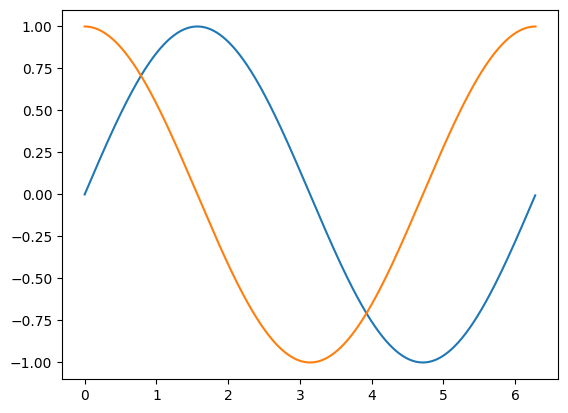

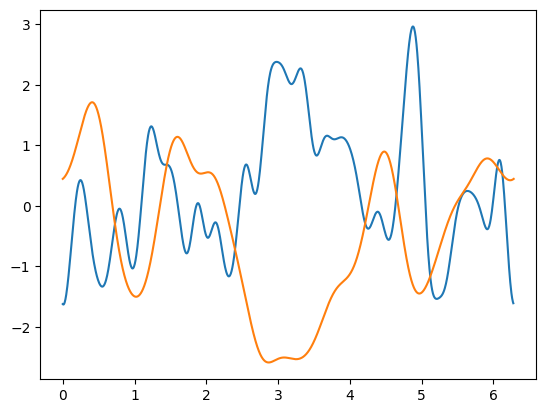

(v,Au) =  -9.758627163092559
(A*v,u) = -9.758627163092566


In [14]:
import matplotlib.pyplot as plt
from pygeoinf.symmetric_space.circle import Sobolev


# Set up the spaces. Note the length scales can vary between the two. 
order = 2
length_scale_1 = 0.1
length_scale_2 = 0.3
X = Sobolev.from_sobolev_parameters(order,length_scale_1)
Y = Sobolev.from_sobolev_parameters(order-1,length_scale_2)

# Define the derivative mapping
def mapping(u):
    coeff = X.to_coefficient(u)
    for k in range(coeff.size):
        coeff[k] *= 1j * k
    return Y.from_coefficient(coeff)

# Define the formal adjoint. Note that this
# needs a separate definition because the two 
# spaces have different spatial discretisations. 
def formal_adjoint_mapping(v):
    coeff = Y.to_coefficient(v)
    for k in range(coeff.size):
        coeff[k] *= -1j * k
    return X.from_coefficient(coeff)

    
# Set up the operator. 
A = LinearOperator(X, Y, mapping, formal_adjoint_mapping=formal_adjoint_mapping)

# Define a function on the domain
u = X.project_function(lambda th : np.sin(th))
v = A(u)

fig, ax = plt.subplots()
X.plot(u, fig=fig, ax=ax)
Y.plot(v, fig=fig, ax=ax)
plt.show()

# Check the adjoint identity using random functions. 
mu = X.heat_gaussian_measure(0.1, 1)
nu = Y.heat_gaussian_measure(0.2,1)

u = mu.sample()
v = nu.sample()

fig, ax = plt.subplots()
X.plot(u, fig=fig, ax=ax)
Y.plot(v, fig=fig, ax=ax)
plt.show()

print(f'(v,Au) =  {Y.inner_product(v, A(u))}')
print(f'(A*v,u) = {X.inner_product(A.adjoint(v), u)}')


### ```LinearOperators``` linked to a ```HilbertSpace```

Each ```HilbertSpace``` has methods that return a set of standard linear operators:

- ```coordinate_inclusion```: A property that returns $I_{X}$ as a ```LinearOperator``` from the appropriate ```EuclideanSpace``` into the space. 
- ```coordinate_projection```: A property that returns $P_{X}$ as a ```LinearOperator``` from the space into the appropriate ```EuclideanSpace```.
- ```riesz```: A property that returns $J_{X}$ as a ```LinearOperator``` from the dual onto the space. 
- ```inverse_riesz```: A property that returns $J_{X}^{-1}$ as a ```LinearOperator``` from the space to its dual.
- ```identity_operator```: A method that returns the identity operator on the space. 
- ```zero_operator```: A method that returns the zero operator on the space. Optinally, the codomain can be provided through the keyword argument, ````codomain```. 

The various ```HilbertSpaces``` that have been implemented within ```pygeoinf``` often have more specific linear operators pre-defined. For example, $H^{s}(\mathbb{S}^{1})$ has ```point_evaluation_operator``` that maps an element to its values at a set of points. This method was used within Tutorial 1 to define the forward operator within the inverse problem considered. 